# Tomato Leaf Disease Detection with MobileNetV2 

## Step 1: Import Libraries

Import all necessary libraries for the project.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Verify GPU detection
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("All Physical Devices:", tf.config.list_physical_devices())


TensorFlow Version: 2.19.0
GPU Available: []
All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Step 2: Define Paths and Constants

Define the dataset paths, expected class names, and training constants. Adjusted to match original learning rate.


In [ ]:
# Define paths to the dataset
base_dir = r"/home/ubuntuwsl/Tomato_Disease_Recognition/data"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# Expected class names (11 classes)
EXPECTED_CLASSES = [
    "Bacterial_spot",
    "Early_blight",
    "Late_blight",
    "Leaf_Mold",
    "Septoria_leaf_spot",
    "Spider_mites Two-spotted_spider_mite",
    "Target_Spot",
    "Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato_mosaic_virus",
    "healthy",
    "powdery_mildew"
]

# Define constants
IMG_SIZE = (224, 224)  # MobileNetV2 default input size
NUM_CLASSES = len(EXPECTED_CLASSES)  # 11 classes
BATCH_SIZE = 16  # Reduced to lower GPU memory usage
EPOCHS = 100  # Increased to give the model more time to learn
FINE_TUNE_EPOCHS = 20
WARMUP_EPOCHS = 5  # Added for warmup
INITIAL_LR = 1e-6  # Match original run
TARGET_LR = 1.55e-5  # Adjusted to match warmup schedule (1e-6 to 3.9e-6 by Epoch 2)


## Step 3: Validate Dataset Structure

Validate that the dataset directory structure matches the expected class names.


In [3]:
# Validate dataset structure
def validate_dataset(data_dir, dataset_type="train"):
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"{dataset_type} directory not found at {data_dir}")
    
    class_names = sorted(os.listdir(data_dir))
    if class_names != EXPECTED_CLASSES:
        raise ValueError(f"Dataset at {data_dir} does not match expected tomato leaf classes. Expected: {EXPECTED_CLASSES}, Found: {class_names}")

# Validate dataset
validate_dataset(train_dir, "train")
validate_dataset(valid_dir, "valid")


FileNotFoundError: train directory not found at /home/ubuntuwsl/Tomato_Disease_Recognition/data\train

## Step 4: Load and Preprocess Data

Set up data augmentation and load the training and validation datasets. Compute class weights and check class distribution.


In [ ]:
# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.95, 1.05]
)

# Define data augmentation for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Get class names and indices
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

# Compute class weights
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Debug: Check class distribution
train_class_counts = np.bincount(train_generator.classes)
train_class_distribution = dict(zip(class_names, train_class_counts))
print("Class distribution in training data:", train_class_distribution)

val_class_counts = np.bincount(val_generator.classes)
val_class_distribution = dict(zip(class_names, val_class_counts))
print("Class distribution in validation data:", val_class_distribution)


Found 25847 images belonging to 11 classes.
Found 6682 images belonging to 11 classes.
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
Class weights: {0: np.float64(0.8314675416586245), 1: np.float64(0.9571190520274023), 2: np.float64(0.754811202289519), 3: np.float64(0.8532052551660395), 4: np.float64(0.8153113368241751), 5: np.float64(1.3450070250299215), 6: np.float64(1.2861123550778724), 7: np.float64(1.154090016074299), 8: np.float64(1.0913735590930203), 9: np.float64(0.7704023845007452), 10: np.float64(2.3403658094893154)}
Class distribution in training data: {'Bacterial_spot': np.int64(2826), 'Early_blight': np.int64(2455), 'Late_blight': np.int64(3113), 'Leaf_Mold': np.int64(2754), 'Septoria_leaf_spot': np.int64(2882), 'Spider_mites Two-spotted_spider_mite': np.int64(1747), 'Target_Spot': np.int

## Step 5: Debug Data Pipeline

Visualize sample images and check the pixel value range to ensure proper normalization.


Sample training images:


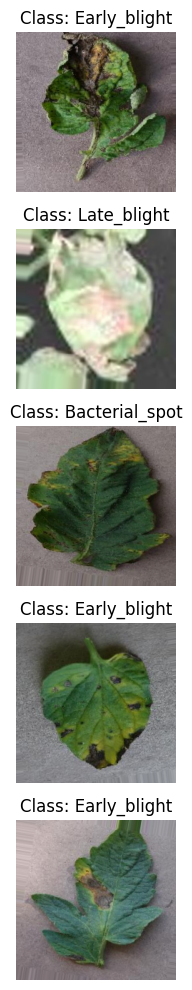

Pixel value range: Min=0.0000, Max=1.0000


In [ ]:
# Debug data pipeline
def debug_data_pipeline(generator, num_samples=5):
    print("Sample training images:")
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 2 * num_samples))
    for i in range(min(num_samples, len(x_batch))):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Pixel value range: Min={x_batch.min():.4f}, Max={x_batch.max():.4f}")

debug_data_pipeline(train_generator)


## Step 6: Define MobileNetV2 Model

Create the MobileNetV2 model with a custom top for classification.


In [ ]:
# Define MobileNetV2 model
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
conv_base.trainable = False  # Freeze the base model initially

model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


I0000 00:00:1743181031.153847    3132 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,924,619 (11.16 MB)

 Trainable params: 664,075 (2.53 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## Step 7: Compile the Model

Compile the model with appropriate optimizer and loss function.


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Step 8: Define Callbacks

Define callbacks for early stopping, model checkpointing, learning rate reduction, warmup, gradient monitoring, and sample predictions.


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    os.path.join(base_dir, "best_model_initial.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Custom callback for learning rate warmup
class WarmUpLearningRate(Callback):
    def __init__(self, warmup_epochs, initial_lr, target_lr):
        super(WarmUpLearningRate, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
            self.model.optimizer.learning_rate.assign(lr)
            print(f"Warmup Epoch {epoch+1}: Setting learning rate to {lr}")

warmup = WarmUpLearningRate(WARMUP_EPOCHS, INITIAL_LR, TARGET_LR)

# Custom callback to monitor gradient norms every 100 batches
class GradientNormCallback(Callback):
    def __init__(self, log_interval=100):
        super(GradientNormCallback, self).__init__()
        self.log_interval = log_interval
        self.batch_count = 0

    def on_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.log_interval == 0:
            gradients = []
            with tf.GradientTape() as tape:
                x_batch, y_batch = next(train_generator)
                predictions = self.model(x_batch, training=True)
                loss = self.model.compiled_loss(y_batch, predictions)
            grads = tape.gradient(loss, self.model.trainable_weights)
            grad_norm = tf.sqrt(sum([tf.reduce_sum(tf.square(g)) for g in grads if g is not None]))
            print(f"Batch {self.batch_count}: Average gradient norm = {grad_norm:.4f}")

gradient_monitor = GradientNormCallback(log_interval=100)

# Custom callback to show sample predictions after each epoch
class SamplePredictionCallback(Callback):
    def __init__(self, generator, num_samples=5):
        super(SamplePredictionCallback, self).__init__()
        self.generator = generator
        self.num_samples = num_samples
        self.class_names = list(generator.class_indices.keys())

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nSample predictions after epoch {epoch + 1}:")
        self.generator.reset()
        x_batch, y_batch = next(self.generator)
        predictions = self.model.predict(x_batch, verbose=0)
        y_true = np.argmax(y_batch, axis=1)
        y_pred = np.argmax(predictions, axis=1)
        for i in range(min(self.num_samples, len(x_batch))):
            true_label = self.class_names[y_true[i]]
            pred_label = self.class_names[y_pred[i]]
            print(f"Sample {i+1}: True = {true_label}, Predicted = {pred_label}")
        print()

sample_prediction_callback = SamplePredictionCallback(val_generator, num_samples=5)


## Step 9: Train the Model (Initial Training)

Train the model with the frozen base layers, including all callbacks.


In [ ]:
# Train the model
print("Training the model (initial phase)...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr, warmup, gradient_monitor, sample_prediction_callback],
    class_weight=class_weights,
    verbose=1
)

# Save the initial trained model
model.save(os.path.join(base_dir, "mobilenetv2_initial_model.keras"))


Training the model (initial phase)...
Warmup Epoch 1: Setting learning rate to 1e-06
Epoch 1/100


/home/ubuntuwsl/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743181037.356850    3274 service.cc:152] XLA service 0x7f76d4011580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743181037.356872    3274 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-03-28 16:57:17.460453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743181038.036169    3274 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1616 ━━━━━━━━━━━━━━━━━━━━ 1:31 56ms/step - accuracy: 0.1007 - loss: 11.4399 

I0000 00:00:1743181044.535829    3274 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  99/1616 ━━━━━━━━━━━━━━━━━━━━ 2:11 87ms/step - accuracy: 0.0961 - loss: 10.9777

/home/ubuntuwsl/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


Batch 100: Average gradient norm = 14.0441
 199/1616 ━━━━━━━━━━━━━━━━━━━━ 2:15 96ms/step - accuracy: 0.0948 - loss: 10.8853Batch 200: Average gradient norm = 15.4443
 299/1616 ━━━━━━━━━━━━━━━━━━━━ 2:13 102ms/step - accuracy: 0.0945 - loss: 10.8340Batch 300: Average gradient norm = 13.5648
 399/1616 ━━━━━━━━━━━━━━━━━━━━ 1:59 98ms/step - accuracy: 0.0949 - loss: 10.8027Batch 400: Average gradient norm = 15.1186
 499/1616 ━━━━━━━━━━━━━━━━━━━━ 1:58 106ms/step - accuracy: 0.0960 - loss: 10.7758Batch 500: Average gradient norm = 14.6055
 599/1616 ━━━━━━━━━━━━━━━━━━━━ 1:49 108ms/step - accuracy: 0.0969 - loss: 10.7556Batch 600: Average gradient norm = 14.1577
 699/1616 ━━━━━━━━━━━━━━━━━━━━ 1:36 105ms/step - accuracy: 0.0978 - loss: 10.7397Batch 700: Average gradient norm = 14.1794
 799/1616 ━━━━━━━━━━━━━━━━━━━━ 1:24 103ms/step - accuracy: 0.0986 - loss: 10.7262Batch 800: Average gradient norm = 13.6020
 899/1616 ━━━━━━━━━━━━━━━━━━━━ 1:12 101ms/step - accuracy: 0.0993 - loss: 10.7146Batch 900:

2025-03-28 17:00:06.198845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 48 bytes spill stores, 48 bytes spill loads

2025-03-28 17:00:06.233998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 264 bytes spill stores, 264 bytes spill loads

2025-03-28 17:00:20.126760: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 124 bytes spill stores, 124 bytes spill loads

2025-03-28 17:00:20.183672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 256 bytes spill stores, 256 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.17091, saving model to /home/ubuntuwsl/Tomato_Disease_Recognition/data/best_model_initial.keras

Sample predictions after epoch 1:
Sample 1: True = Bacterial_spot, Predicted = healthy
Sample 2: True = Bacterial_spot, Predicted = powdery_mildew
Sample 3: True = Bacterial_spot, Predicted = Bacterial_spot
Sample 4: True = Bacterial_spot, Predicted = healthy
Sample 5: True = Bacterial_spot, Predicted = powdery_mildew

1616/1616 ━━━━━━━━━━━━━━━━━━━━ 191s 113ms/step - accuracy: 0.1033 - loss: 10.6494 - val_accuracy: 0.1709 - val_loss: 9.7605 - learning_rate: 1.0000e-06
Warmup Epoch 2: Setting learning rate to 3.9e-06
Epoch 2/100
  83/1616 ━━━━━━━━━━━━━━━━━━━━ 2:12 86ms/step - accuracy: 0.1618 - loss: 10.2245Batch 1700: Average gradient norm = 13.8292
 183/1616 ━━━━━━━━━━━━━━━━━━━━ 2:24 101ms/step - accuracy: 0.1481 - loss: 10.1879Batch 1800: Average gradient norm = 14.5553
 283/1616 ━━━━━━━━━━━━━━━━━━━━ 2:08 97ms/step - accuracy: 0.1465 - loss: 

## Step 10: Plot Training History

Plot the training and validation accuracy and loss.


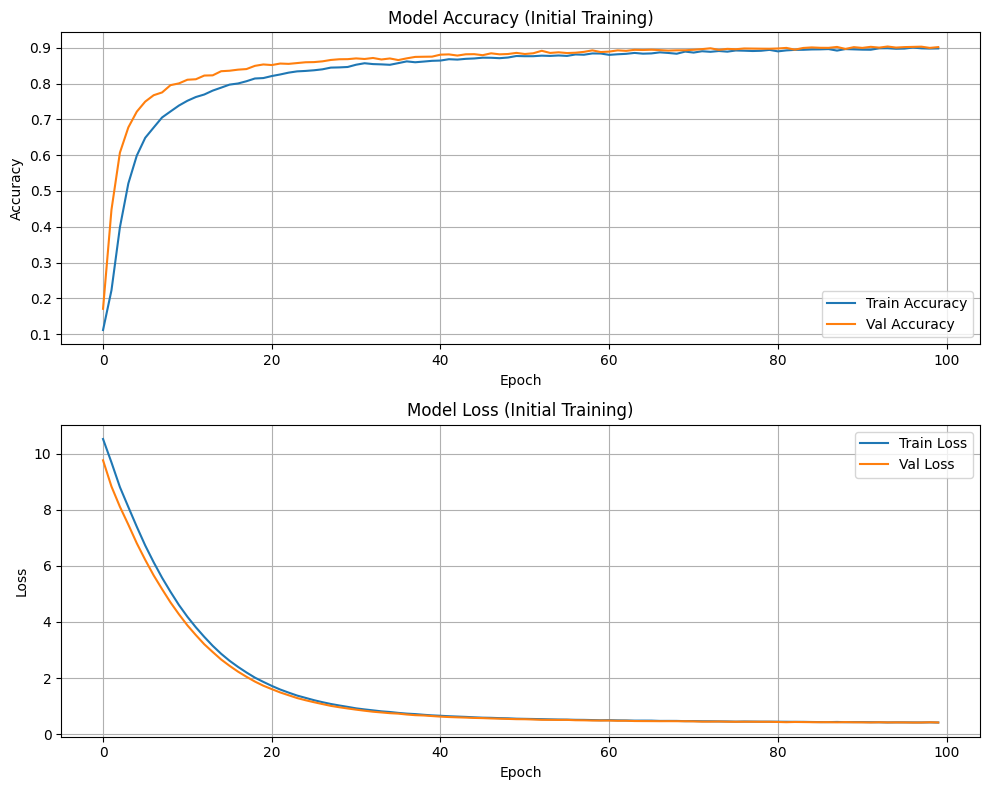

In [ ]:
# Plot training history
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(base_dir, "initial_training_history.png"))
plt.show()


## Step 11: Evaluate the Model (Initial Training)

Evaluate the model on the validation dataset and compute additional metrics.


Evaluating the model on validation data after initial training...
418/418 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step
Accuracy (Initial Training): 0.9026
F1 Score (Initial Training): 0.9025
MCC (Initial Training): 0.8923

Classification Report:
                                       precision    recall  f1-score   support

                      Bacterial_spot       0.92      0.93      0.93       732
                        Early_blight       0.90      0.81      0.85       643
                         Late_blight       0.90      0.90      0.90       792
                           Leaf_Mold       0.89      0.94      0.91       739
                  Septoria_leaf_spot       0.86      0.82      0.84       746
Spider_mites Two-spotted_spider_mite       0.96      0.80      0.87       435
                         Target_Spot       0.75      0.91      0.82       457
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.96      0.98       498
                 Tomato_mosaic_virus       0.96      0.93   

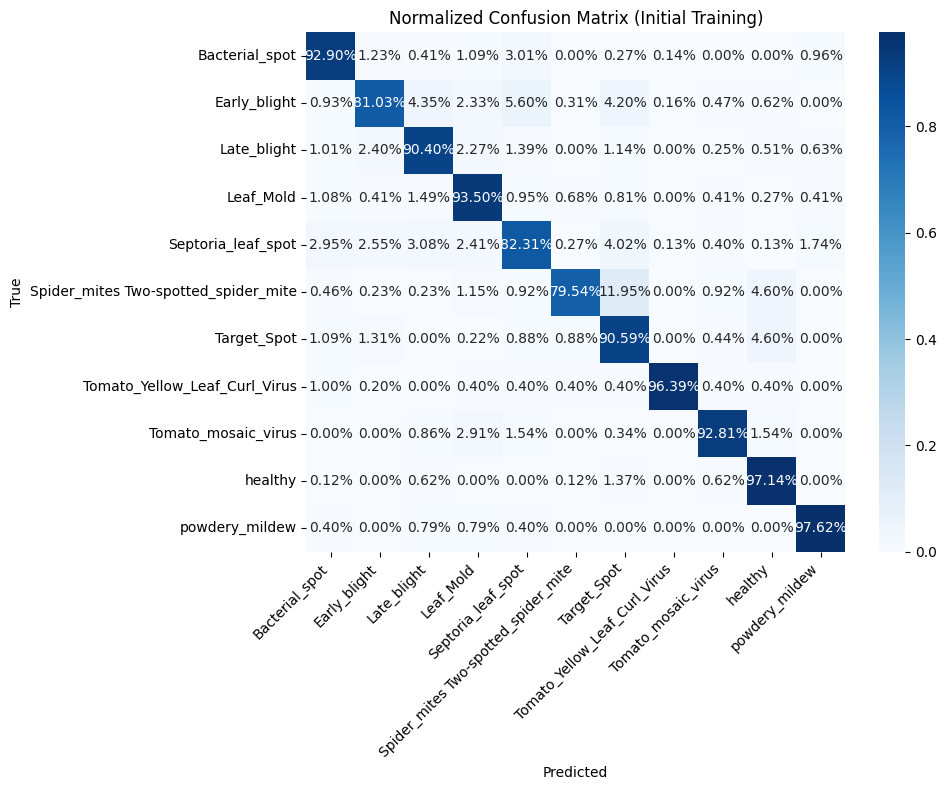

Final Training Accuracy (Initial Training): 0.8981
Final Validation Accuracy (Initial Training): 0.9018
Difference (Train - Val): -0.0037


In [ ]:
# Evaluate the model on validation data after initial training
print("Evaluating the model on validation data after initial training...")
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = val_generator.classes

acc = accuracy_score(y_val_classes, y_pred_classes)
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_val_classes, y_pred_classes)
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')

print(f"Accuracy (Initial Training): {acc:.4f}")
print(f"F1 Score (Initial Training): {f1:.4f}")
print(f"MCC (Initial Training): {mcc:.4f}")
print("\nClassification Report:\n", classification_report(y_val_classes, y_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix (Initial Training)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "confusion_matrix_initial.png"))
plt.show()

# Check for overfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy (Initial Training): {final_train_acc:.4f}")
print(f"Final Validation Accuracy (Initial Training): {final_val_acc:.4f}")
print(f"Difference (Train - Val): {final_train_acc - final_val_acc:.4f}")


## Step 12: Adjust Class Weights (Optional)

Adjust class weights if needed based on initial performance.


In [ ]:
# Adjust class weights if necessary (optional)
adjusted_class_weights = class_weights.copy()
# Example adjustment (uncomment and modify if needed):
# for cls in range(NUM_CLASSES):
#     if cls in [idx for idx, name in enumerate(class_names) if 'healthy' in name]:
#         adjusted_class_weights[cls] *= 0.9  # Reduce weight for healthy class
print("Adjusted Class Weights:", adjusted_class_weights)


Adjusted Class Weights: {0: np.float64(0.8314675416586245), 1: np.float64(0.9571190520274023), 2: np.float64(0.754811202289519), 3: np.float64(0.8532052551660395), 4: np.float64(0.8153113368241751), 5: np.float64(1.3450070250299215), 6: np.float64(1.2861123550778724), 7: np.float64(1.154090016074299), 8: np.float64(1.0913735590930203), 9: np.float64(0.7704023845007452), 10: np.float64(2.3403658094893154)}


## Step 13: Check Gradient Norms (Optional)

Define a custom callback to monitor gradient norms during training (already defined in Step 8).


In [ ]:
# GradientNormCallback is already defined in Step 8
print("GradientNormCallback is already defined and will be used during training.")


GradientNormCallback is already defined and will be used during training.


## Step 14: Verify Model Architecture

Re-check the model architecture before fine-tuning.


In [ ]:
# Verify model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,252,771 (16.22 MB)

 Trainable params: 664,075 (2.53 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

 Optimizer params: 1,328,152 (5.07 MB)

## Step 15: Save Initial Model

Ensure the initial model is saved before proceeding to fine-tuning.


In [ ]:
# Save the initial model again for safety
model.save(os.path.join(base_dir, "mobilenetv2_initial_model_backup.keras"))
print("Initial model backup saved.")


Initial model backup saved.


## Step 16: Fine-Tune the Model

Unfreeze some layers of the base model and fine-tune with a smaller learning rate, optimized to prevent kernel crashes.


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Paths
base_dir = r"/home/ubuntuwsl/Tomato_Disease_Recognition/data"
model_path = os.path.join(base_dir, "mobilenetv2_initial_model.keras")

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Ensure initial training is complete.")

# Load the pre-trained model
model = load_model(model_path)
print("Loaded the initial trained model from:", model_path)

# Fine-tune by unfreezing all but the first 50 layers
conv_base = model.layers[0]  # MobileNetV2 base
conv_base.trainable = True
for layer in conv_base.layers[:50]:  # Keep first 50 layers frozen
    layer.trainable = False

# Compile with a very small learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Paths to dataset
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,  # More rotation
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.20,  # More zoom
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.85, 1.15],  # More brightness variance
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42
)
val_generator = val_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=42
)

# Compute class weights for balanced training
train_labels = train_generator.classes
adjusted_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
adjusted_class_weights = dict(enumerate(adjusted_class_weights))

# Callbacks
checkpoint_finetune = ModelCheckpoint(
    os.path.join(base_dir, "best_model_finetuned.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Stops training if no improvement in 10 epochs
    restore_best_weights=True,
    verbose=1
)

# Training parameters
FINE_TUNE_EPOCHS = 40  # Extended fine-tuning
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Fine-tune the model
print("Fine-tuning the model...")
try:
    history_fine = model.fit(
        train_generator,
        epochs=FINE_TUNE_EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint_finetune],
        class_weight=adjusted_class_weights,
        verbose=1
    )
except Exception as e:
    print(f"Fine-tuning interrupted due to error: {e}")
    raise

# Save the fine-tuned model
model.save(os.path.join(base_dir, "mobilenetv2_finetuned_model.keras"))
print("Fine-tuned model saved successfully.")


Loaded the initial trained model from: /home/ubuntuwsl/Tomato_Disease_Recognition/data/mobilenetv2_initial_model.keras
Found 25847 images belonging to 11 classes.
Found 6682 images belonging to 11 classes.
Fine-tuning the model...


/home/ubuntuwsl/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7133 - loss: 0.9150

2025-03-29 11:40:57.391384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 208 bytes spill stores, 208 bytes spill loads

2025-03-29 11:40:57.413240: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 264 bytes spill stores, 264 bytes spill loads

2025-03-29 11:40:57.422602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 48 bytes spill stores, 48 bytes spill loads

2025-03-29 11:41:08.656467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1229', 4 bytes spill stores, 4 bytes spill loads

2025-03-29 11:41:08.804190: I external


Epoch 1: val_accuracy improved from -inf to 0.81832, saving model to /home/ubuntuwsl/Tomato_Disease_Recognition/data/best_model_finetuned.keras
808/808 ━━━━━━━━━━━━━━━━━━━━ 200s 223ms/step - accuracy: 0.7134 - loss: 0.9148 - val_accuracy: 0.8183 - val_loss: 0.6794 - learning_rate: 1.0000e-05
Epoch 2/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8451 - loss: 0.5333
Epoch 2: val_accuracy improved from 0.81832 to 0.87863, saving model to /home/ubuntuwsl/Tomato_Disease_Recognition/data/best_model_finetuned.keras
808/808 ━━━━━━━━━━━━━━━━━━━━ 158s 195ms/step - accuracy: 0.8452 - loss: 0.5333 - val_accuracy: 0.8786 - val_loss: 0.4713 - learning_rate: 1.0000e-05
Epoch 3/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8809 - loss: 0.4355
Epoch 3: val_accuracy improved from 0.87863 to 0.91110, saving model to /home/ubuntuwsl/Tomato_Disease_Recognition/data/best_model_finetuned.keras
808/808 ━━━━━━━━━━━━━━━━━━━━ 156s 194ms/step - accuracy: 0.8809 - loss: 0.4355 - val_ac

## Step 17: Plot Fine-Tuning History

Plot the training and validation accuracy and loss during fine-tuning with error handling.


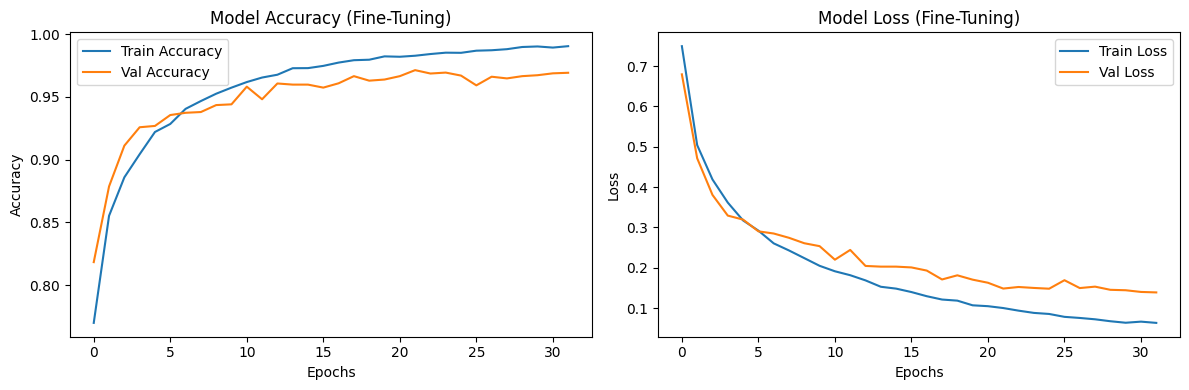

In [ ]:
# Step 17: Plot fine-tuning history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 18: Evaluate the Fine-Tuned Model

Evaluate the fine-tuned model on the validation dataset with batch-wise prediction.


Loaded the fine-tuned model from: /home/ubuntuwsl/Tomato_Disease_Recognition/data/mobilenetv2_finetuned_model.keras
Found 6682 images belonging to 11 classes.
Evaluating the model on validation data after fine-tuning...


2025-03-29 13:41:49.630308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1172', 256 bytes spill stores, 256 bytes spill loads

2025-03-29 13:41:49.641351: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1172', 124 bytes spill stores, 124 bytes spill loads

2025-03-29 13:45:23.010139: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1172', 124 bytes spill stores, 124 bytes spill loads

2025-03-29 13:45:23.051096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1172', 256 bytes spill stores, 256 bytes spill loads



Accuracy (Fine-Tuning): 0.9711
F1 Score (Fine-Tuning, Weighted): 0.9713
MCC (Fine-Tuning): 0.9681

Classification Report:
                                       precision    recall  f1-score   support

                      Bacterial_spot       0.99      0.96      0.98       732
                        Early_blight       0.97      0.92      0.94       643
                         Late_blight       0.96      0.98      0.97       792
                           Leaf_Mold       0.98      0.98      0.98       739
                  Septoria_leaf_spot       0.97      0.97      0.97       746
Spider_mites Two-spotted_spider_mite       1.00      0.95      0.97       435
                         Target_Spot       0.87      1.00      0.93       457
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       498
                 Tomato_mosaic_virus       0.99      0.97      0.98       584
                             healthy       0.98      0.99      0.98       804
                  

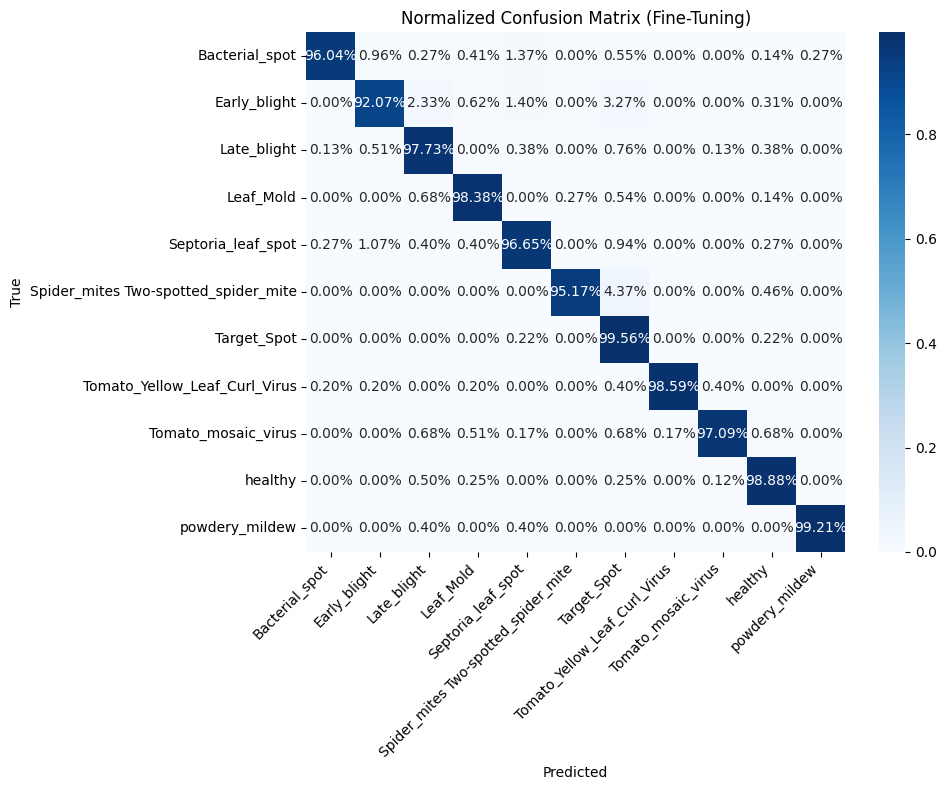

Training history (history_fine) not available. Please use the validation accuracy from the graph (~0.96-0.97).


In [ ]:
# Step 18: Evaluate the fine-tuned model
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and constants
base_dir = r"/home/ubuntuwsl/Tomato_Disease_Recognition/data"
model_path = os.path.join(base_dir, "mobilenetv2_finetuned_model.keras")
valid_dir = os.path.join(base_dir, "valid")
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Reduced to prevent kernel crashes
NUM_CLASSES = 11

# Load the fine-tuned model
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Ensure Step 16 was completed and the model was saved.")

model = load_model(model_path)
print("Loaded the fine-tuned model from:", model_path)

# Define data augmentation for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Evaluate the model on validation data after fine-tuning
print("Evaluating the model on validation data after fine-tuning...")

# Reset the validation generator
val_generator.reset()
val_generator.shuffle = False  # Ensure consistent order for evaluation

# Get predictions and true labels
val_steps = val_generator.samples // BATCH_SIZE
if val_generator.samples % BATCH_SIZE != 0:
    val_steps += 1  # Account for remaining samples

y_pred = []
y_true = []
for i in range(val_steps):
    try:
        X_batch, y_batch = next(val_generator)
        y_pred_batch = model.predict(X_batch, verbose=0)
        y_pred.extend(y_pred_batch)
        y_true.extend(y_batch)
        # Clear memory after each batch
        del X_batch, y_batch, y_pred_batch
        import gc
        gc.collect()
    except Exception as e:
        print(f"Error during prediction at step {i}: {e}")
        break

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_true, axis=1)

# Compute metrics
acc = accuracy_score(y_val_classes, y_pred_classes)
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
mcc = matthews_corrcoef(y_val_classes, y_pred_classes)
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')

# Print metrics
print(f"Accuracy (Fine-Tuning): {acc:.4f}")
print(f"F1 Score (Fine-Tuning, Weighted): {f1:.4f}")
print(f"MCC (Fine-Tuning): {mcc:.4f}")
print("\nClassification Report:\n", classification_report(y_val_classes, y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=list(val_generator.class_indices.keys()), yticklabels=list(val_generator.class_indices.keys()))
plt.title("Normalized Confusion Matrix (Fine-Tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "confusion_matrix_finetuned.png"))
plt.show()

# Check for overfitting (using the fine-tuning history)
# Note: Since history_fine may not be available after a kernel restart, you can load it if saved, or skip this part
try:
    final_train_acc = history_fine.history['accuracy'][-1]
    final_val_acc = history_fine.history['val_accuracy'][-1]
    print(f"Final Training Accuracy (Fine-Tuning): {final_train_acc:.4f}")
    print(f"Final Validation Accuracy (Fine-Tuning): {final_val_acc:.4f}")
    print(f"Difference (Train - Val): {final_train_acc - final_val_acc:.4f}")
except NameError:
    print("Training history (history_fine) not available. Please use the validation accuracy from the graph (~0.96-0.97).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


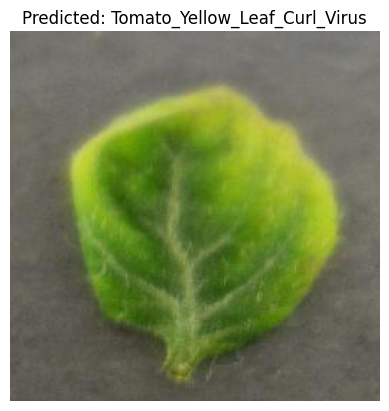

Prediction Confidence Scores:
Bacterial_spot: 0.0003
Early_blight: 0.0000
Late_blight: 0.0001
Leaf_Mold: 0.0000
Septoria_leaf_spot: 0.0000
Spider_mites Two-spotted_spider_mite: 0.0000
Target_Spot: 0.0000
Tomato_Yellow_Leaf_Curl_Virus: 0.9994
Tomato_mosaic_virus: 0.0001
healthy: 0.0000
powdery_mildew: 0.0000


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the fine-tuned model
model_path = os.path.join(base_dir, "mobilenetv2_finetuned_model.keras")
model = tf.keras.models.load_model(model_path)

# Define image preprocessing function
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array

# Provide the image path for testing
test_image_path = r"/home/ubuntuwsl/Tomato_Disease_Recognition/data/valid/Tomato_Yellow_Leaf_Curl_Virus/22103d3e-3b76-4cc4-9d78-12db97bde78f___UF.GRC_YLCV_Lab 02977.JPG"  # Change this to your image path
img_array = preprocess_image(test_image_path)

# Make a prediction
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)[0]

# Get class labels from the validation generator
class_labels = list(val_generator.class_indices.keys())  # Ensure val_generator is initialized
predicted_label = class_labels[predicted_class]

# Display the image with prediction
plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

# Print the confidence scores
print("Prediction Confidence Scores:")
for i, label in enumerate(class_labels):
    print(f"{label}: {pred[0][i]:.4f}")
